In [85]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import chart_studio.plotly as ply
import cufflinks as cf
from arch import arch_model
from tbats import BATS, TBATS
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (8,5)
import warnings
warnings.filterwarnings('ignore')


In [2]:
df_us = pd.read_csv('us.csv')

In [3]:
df_us.set_index('date', inplace = True)

In [4]:
df_us.shape

(239, 2)

In [5]:
df_us.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


<AxesSubplot:xlabel='date'>

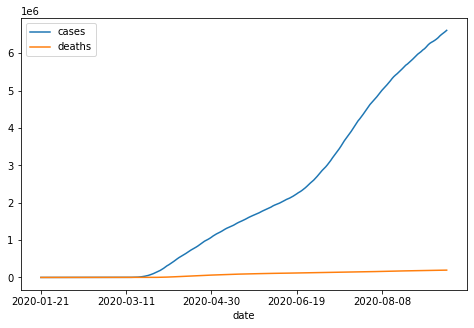

In [6]:
df_us.plot()

In [7]:
df_us['case_day'] = df_us['cases'].diff()
df_us['case_day'][0] = 1
df_us['case_day'] =  df_us['case_day'].astype('int')

In [8]:
df_us['case_day']

date
2020-01-21        1
2020-01-22        0
2020-01-23        0
2020-01-24        1
2020-01-25        1
              ...  
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, Length: 239, dtype: int32

In [9]:
df_us['case_day'].describe()

count      239.000000
mean     27674.108787
std      21008.903281
min          0.000000
25%       6067.500000
50%      26237.000000
75%      43120.000000
max      75682.000000
Name: case_day, dtype: float64

<AxesSubplot:xlabel='date', ylabel='New Cases per Day'>

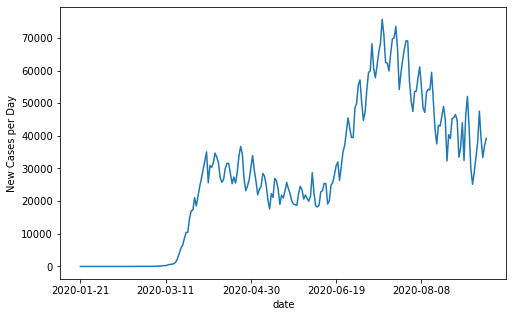

In [10]:
df_us['case_day'].plot(ylabel = 'New Cases per Day')


In [11]:
test = adfuller(df_us['case_day'])
test_cases_day = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_cases_day)
# P-value > 0.05 Not Stationary


Test Statstic                   -1.744789
p-value                          0.408196
#Lags Used                       0.000000
Number of Observations Used    238.000000
dtype: float64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

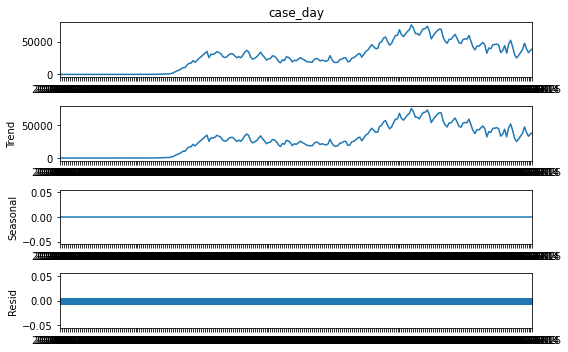

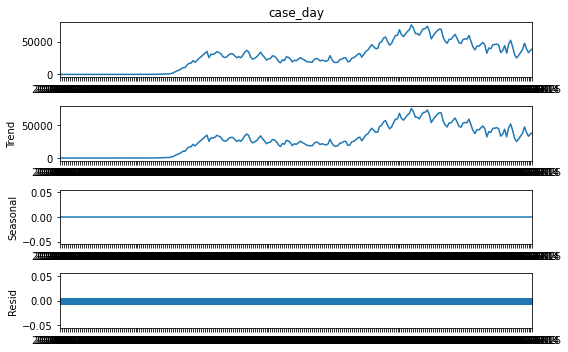

In [79]:
sd = seasonal_decompose(df_us['case_day'], model='additive', freq=1)
sd.plot()
#pyplot.show()

## Differencing 


In [12]:
diff1 = df_us['case_day'] - df_us['case_day'].shift(1)

In [13]:
diff1 = diff1.dropna()

In [14]:
test = adfuller(diff1)
test_diff1 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff1)
# pvalue still > 0.05 

Test Statstic                   -2.260045
p-value                          0.185178
#Lags Used                      14.000000
Number of Observations Used    223.000000
dtype: float64


In [15]:
diff2 = diff1 - diff1.shift(1)
diff2 = diff2.dropna()

In [16]:
test = adfuller(diff2)
test_diff2 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff2)
# pvalue still > 0.05 

Test Statstic                 -6.783965e+00
p-value                        2.458934e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.230000e+02
dtype: float64


### p-value < 0.05 
Series stationary at d = 2

## Plotting ACF and PACF

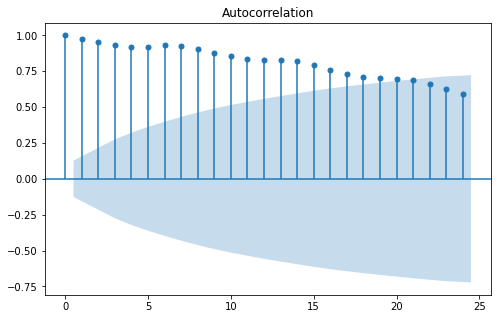

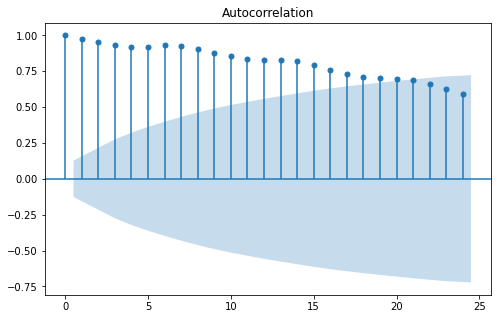

In [17]:
plot_acf(df_us['case_day'], alpha = 0.05) # q = 1-20

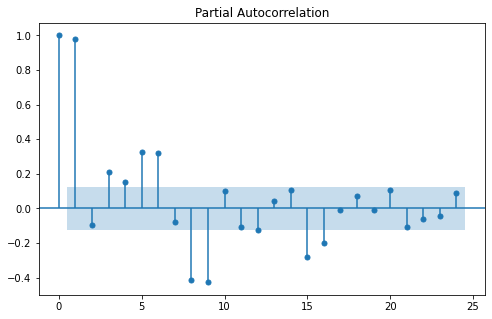

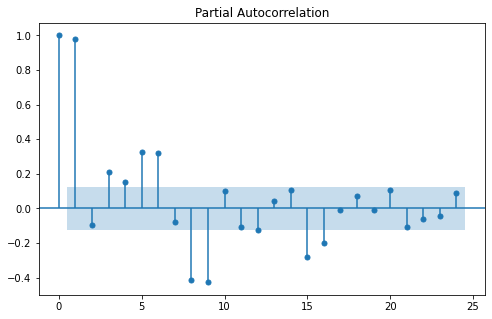

In [18]:
plot_pacf(df_us['case_day'], alpha = 0.05) # p = 3

## Train Test Split

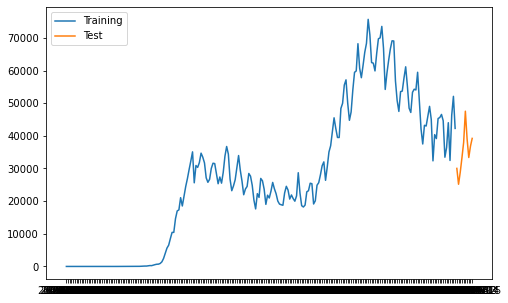

In [19]:
train = df_us['case_day'].loc['2020-01-21':'2020-09-05']
test = df_us['case_day'].loc['2020-09-06':]
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.show()

## ARIMA model

In [20]:
arima = ARIMA(train, order=(2, 2, 2))
arima_fit = arima.fit(disp= 0)
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.case_day   No. Observations:                  227
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2183.376
Method:                       css-mle   S.D. of innovations           3609.183
Date:                Sun, 20 Sep 2020   AIC                           4378.752
Time:                        12:06:34   BIC                           4399.301
Sample:                    01-23-2020   HQIC                          4387.044
                         - 09-05-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2530     22.727      0.055      0.956     -43.290      45.796
ar.L1.D2.case_day     0.7132      0.070     10.235      0.000       0.577       0.850
ar.L2.D2.case_day    -0.

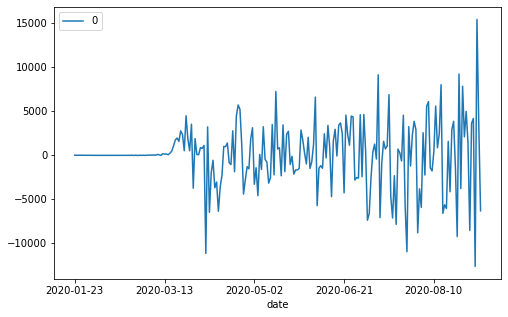

In [21]:
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()

In [22]:
preds = arima_fit.forecast(steps = 10)[0]

In [23]:
preds

array([38363.66840285, 39532.85877425, 42060.04876133, 43604.97966522,
       43928.85161885, 43759.80579642, 43708.83054373, 43932.14062232,
       44306.58267637, 44684.35103226])

In [24]:
np.sqrt(mean_squared_error(preds, test))

9070.773231902464

In [25]:
df_us['case_day'].describe()

count      239.000000
mean     27674.108787
std      21008.903281
min          0.000000
25%       6067.500000
50%      26237.000000
75%      43120.000000
max      75682.000000
Name: case_day, dtype: float64

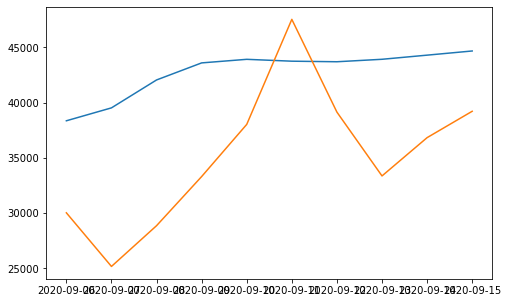

In [26]:
pyplot.plot(preds)
pyplot.plot(test)

### Grid Search for ARIMA

## ARIMA with best parameters

In [28]:
best_arima = ARIMA(train, order=(7, 1, 6))
best_arima_fit = best_arima.fit(disp= 0)


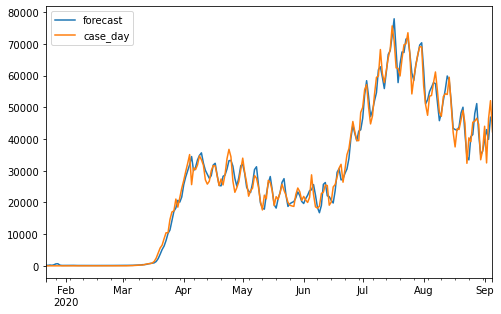

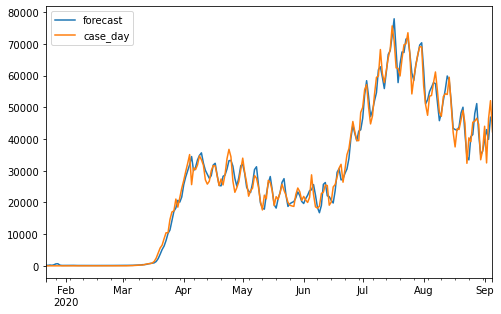

In [29]:
best_arima_fit.plot_predict()

In [31]:
preds = best_arima_fit.forecast(steps = 10)[0]

In [32]:
best_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.case_day   No. Observations:                  228
Model:                 ARIMA(7, 1, 6)   Log Likelihood               -2125.942
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 20 Sep 2020   AIC                           4281.885
Time:                        12:07:02   BIC                           4333.325
Sample:                    01-22-2020   HQIC                          4302.639
                         - 09-05-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              185.4505        nan        nan        nan         nan         nan
ar.L1.D.case_day     0.3445   9.19e-06   3.75e+04      0.000       0.344       0.344
ar.L2.D.case_day    -0.1610        nan        nan        nan         nan         nan
ar.L3.D.case_day    -0.1997   1.81e-06   -1.1e+05      0.000      -0.200      -0.200
ar.L4.D.case_day     0.3565   1.61e-05   2.22e+04      0.000       0.356       0.357
ar.L5.D.case_day    -0.6319        nan        nan        nan         nan         nan
ar.L6.D.case_day     0.5774   4.03e-06   1.43e+05      0.000       0.577       0.577
ar.L7.D.case_day     0.3947        nan        nan        nan         nan         nan
ma.L1.D.case_day    -0.6916      0.049    -14.005      0.000      -0.788      -0.595
ma.L2.D.case_day     0.4061      0.048      8.546      0.000       0.313       0.499
ma.L3.D.case_day     0.0072      0.057      0.126      0.900      -0.105       0.120
ma.L4.D.case_day    -0.4339      0.041    -10.459      0.000      -0.515      -0.353
ma.L5.D.case_day     0.8711      0.062     14.010      0.000       0.749       0.993
ma.L6.D.case_day    -0.6281      0.054    -11.598      0.000      -0.734      -0.522
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0664           -0.0000j            1.0664           -0.0000
AR.2            0.6289           -0.7775j            1.0000           -0.1418
AR.3            0.6289           +0.7775j            1.0000            0.1418
AR.4           -0.2219           -0.9751j            1.0000           -0.2856
AR.5           -0.2219           +0.9751j            1.0000            0.2856
AR.6           -1.0247           -0.0000j            1.0247           -0.5000
AR.7           -2.3186           -0.0000j            2.3186           -0.5000
MA.1           -1.0180           -0.0000j            1.0180           -0.5000
MA.2           -0.1825           -0.9905j            1.0072           -0.2790
MA.3           -0.1825           +0.9905j            1.0072            0.2790
MA.4            0.7616           -0.8103j            1.1121           -0.1299
MA.5            0.7616           +0.8103j            1.1121            0.1299
MA.6            1.2467           -0.0000j            1.2467           -0.0000
-----------------------------------------------------------------------------
"""

In [33]:
best_rmse = np.sqrt(mean_squared_error(preds, test))
print('Best ARIMA RMSE: ',best_rmse)

Best ARIMA RMSE:  6609.899495639759


In [34]:
preds

array([36615.30462049, 36765.99442138, 39297.71359229, 39733.49376976,
       45984.27933713, 50194.65470207, 44271.73178117, 36772.61124462,
       37835.74510717, 39453.06556671])

In [35]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, dtype: int32

## AUTO ARIMA

In [36]:
#test.iplot(title="Energy Production Jan 1985--Jan 2018")

In [37]:
model_auto = auto_arima(train, start_p=1, start_q=1, d = 1,
                           max_p=20, max_q=20, trace=True,
                       error_action='ignore',  m = 1,
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4423.556, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4425.618, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4427.290, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4427.136, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4424.126, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4408.291, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4420.824, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4404.840, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4418.403, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4378.172, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4384.094, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4365.103, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4364.313, Time=0.07 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4361.554, Time=0.10 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept

In [38]:
model_auto_fit = model_auto.fit(train)

In [39]:
preds = model_auto_fit.predict(n_periods = 10)

In [40]:
preds

array([39438.41121831, 40670.07763697, 40429.15763704, 40462.23314101,
       45455.98581621, 52268.97728407, 45374.59972612, 40726.62829301,
       43000.62911724, 41370.526741  ])

In [41]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, dtype: int32

In [42]:
rmse = np.sqrt(mean_squared_error(preds, test))
print('Auto ARIMA RMSE: ',rmse)

Auto ARIMA RMSE:  8522.844911727185


## Simple Exponential Smoothing(SES)

In [43]:
ses = SimpleExpSmoothing(train)
ses_fit = ses.fit()

In [44]:
ses_preds = ses_fit.forecast(steps = 10)

In [45]:
ses_preds

2020-09-06    42278.0
2020-09-07    42278.0
2020-09-08    42278.0
2020-09-09    42278.0
2020-09-10    42278.0
2020-09-11    42278.0
2020-09-12    42278.0
2020-09-13    42278.0
2020-09-14    42278.0
2020-09-15    42278.0
Freq: D, dtype: float64

In [46]:
np.sqrt(mean_squared_error(ses_preds, test))

9363.60943226489

## FBPROPHET

In [47]:
X = pd.DataFrame(train)

In [48]:
X.rename(columns = {'case_day':'y'}, inplace = True)
X.index.names = ['ds']
X.head()

,y
ds,
2020-01-21,1
2020-01-22,0
2020-01-23,0
2020-01-24,1
2020-01-25,1


In [49]:
X['index'] = np.arange(len(X))

In [50]:
X['ds'] = X.index

In [51]:
X.set_index('index', inplace = True)


In [52]:
model = Prophet()
model.fit(X)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
future = model.make_future_dataframe(periods = 10)
future.tail()

,ds
234,2020-09-11
235,2020-09-12
236,2020-09-13
237,2020-09-14
238,2020-09-15


In [54]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
234,2020-09-11,61168.405439,48288.689702,74411.780576
235,2020-09-12,58272.808380,45389.167219,71734.670069
236,2020-09-13,54663.001131,41179.315105,67577.246145
237,2020-09-14,55189.797756,42961.698281,67946.956203
238,2020-09-15,57522.935954,44343.859669,70688.184894


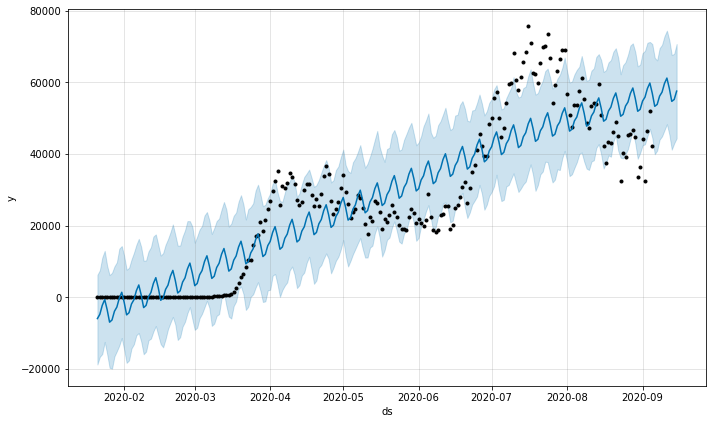

In [55]:
fig1 = model.plot(forecast)


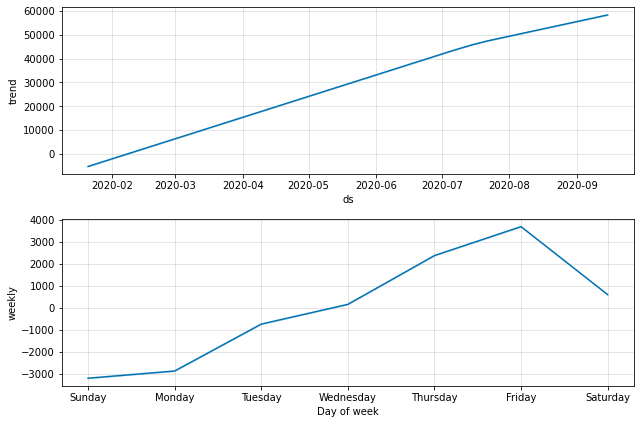

In [56]:
fig2 = model.plot_components(forecast)

In [57]:
#plot_plotly(model, forecast)

In [58]:
#plot_components_plotly(model, forecast)

In [59]:
np.sqrt(mean_squared_error(test, forecast['yhat'].tail(10)))


21954.77179086016

## TBATS

In [60]:
tbats = TBATS()
tbats_fit = tbats.fit(train)

In [61]:
preds_tbats = tbats_fit.forecast(steps=10)

In [62]:
np.sqrt(mean_squared_error(test, preds_tbats))

12598.172869639702

In [63]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, dtype: int32

In [64]:
preds_tbats

array([48534.49965928, 46243.61367383, 42872.92847179, 44862.45162456,
       45462.84611931, 47658.24003515, 48481.77819373, 47357.90360872,
       46284.20757588, 45848.4564317 ])

## DNN

In [65]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d = i+look_back  
        X.append(data_arr[i:d ,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [66]:
testt = test.values
trainn = train.values

In [67]:
look_back = 5

trainX, trainY = convert2matrix(trainn, look_back)
testX, testY = convert2matrix(testt, look_back)

In [68]:
testX

array([[30030, 25173, 28864, 33313, 38036],
       [25173, 28864, 33313, 38036, 47548],
       [28864, 33313, 38036, 47548, 39149],
       [33313, 38036, 47548, 39149, 33369],
       [38036, 47548, 39149, 33369, 36836]])

In [69]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, dtype: int32

In [81]:
dnn = Sequential()
dnn.add(Dense(units=32, input_dim=look_back, activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1))
dnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

In [82]:
dnn_fit = dnn.fit(trainX,trainY, epochs=20, batch_size=30, verbose=1, 
                  validation_data=(testX,testY), )

Epoch 1/20
8/8 [==============================] - 0s 13ms/step - loss: 1169068928.0000 - mse: 1169068928.0000 - mae: 27319.4258 - val_loss: 1351761152.0000 - val_mse: 1351761152.0000 - val_mae: 36454.3672
Epoch 2/20
8/8 [==============================] - 0s 3ms/step - loss: 988336576.0000 - mse: 988336576.0000 - mae: 25046.0488 - val_loss: 1139860352.0000 - val_mse: 1139860352.0000 - val_mae: 33389.8359
Epoch 3/20
8/8 [==============================] - 0s 3ms/step - loss: 813850496.0000 - mse: 813850496.0000 - mae: 22702.1855 - val_loss: 947518080.0000 - val_mse: 947518080.0000 - val_mae: 30332.8535
Epoch 4/20
8/8 [==============================] - 0s 3ms/step - loss: 654518080.0000 - mse: 654518080.0000 - mae: 20311.6621 - val_loss: 741136128.0000 - val_mse: 741136128.0000 - val_mae: 26702.9648
Epoch 5/20
8/8 [==============================] - 0s 3ms/step - loss: 454536672.0000 - mse: 454536672.0000 - mae: 16907.4395 - val_loss: 490597184.0000 - val_mse: 490597184.0000 - val_mae: 2143

In [83]:
train_score = dnn.evaluate(trainX, trainY, verbose=0)
print('Train Score : ', train_score)

Train Score :  [21728906.0, 21728906.0, 3320.485595703125]


In [99]:
test_score = dnn.evaluate(testX, testY, verbose=0)
print('Test Score : ', test_score)

Test Score :  [37560256.0, 37560256.0, 4820.4677734375]


In [120]:
dnn_pred = dnn.predict(testX)

In [121]:
dnn_rmse = np.sqrt(mean_squared_error(dnn_pred,testY))

In [122]:
dnn_rmse

6128.642505088115

## RNN

In [125]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [126]:
rnn = Sequential()
rnn.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
rnn.add(Dense(8, activation='relu'))
rnn.add(Dense(1))
rnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

In [127]:
rnn_fit = rnn.fit(trainX,trainY, epochs=20, batch_size=30, verbose=1, 
                  validation_data=(testX,testY))

Epoch 1/20
8/8 [==============================] - 0s 22ms/step - loss: 2541698304.0000 - mse: 2541698304.0000 - mae: 40198.0391 - val_loss: 2588236032.0000 - val_mse: 2588236032.0000 - val_mae: 50715.1602
Epoch 2/20
8/8 [==============================] - 0s 4ms/step - loss: 1983732736.0000 - mse: 1983732736.0000 - mae: 35502.9219 - val_loss: 2125265536.0000 - val_mse: 2125265536.0000 - val_mae: 45895.6641
Epoch 3/20
8/8 [==============================] - 0s 4ms/step - loss: 1592809088.0000 - mse: 1592809088.0000 - mae: 31813.5586 - val_loss: 1766040320.0000 - val_mse: 1766040320.0000 - val_mae: 41764.3945
Epoch 4/20
8/8 [==============================] - 0s 4ms/step - loss: 1290254976.0000 - mse: 1290254976.0000 - mae: 28643.9551 - val_loss: 1484781312.0000 - val_mse: 1484781312.0000 - val_mae: 38213.3242
Epoch 5/20
8/8 [==============================] - 0s 4ms/step - loss: 1095781760.0000 - mse: 1095781760.0000 - mae: 26407.4824 - val_loss: 1358952832.0000 - val_mse: 1358952832.0000 -

In [128]:
rnn_pred = rnn.predict(testX)

In [129]:
rnn_pred

array([[31328.885],
       [35901.75 ],
       [40368.957],
       [38879.523],
       [40596.387]], dtype=float32)

In [130]:
np.sqrt(mean_squared_error(rnn_pred, testY))

8107.566383733096